# Projeto

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
from pennylane.optimize import AdamOptimizer
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates.embeddings import AngleEmbedding
from tqdm.notebook import tqdm, trange
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import pickle

In [2]:

# Read the HDF5 file using pandas
data_frame_fcnc = pd.read_hdf('fcnc_pythia_sanitised_features.h5')

# Get the number of rows
num_rows = data_frame_fcnc.shape[0]

print('Number of rows: {}'.format(num_rows))

# Explore the data
data_frame_fcnc.head()


Number of rows: 90548


,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,FatJet1_Phi,FatJet1_Tau1,FatJet1_Tau2,FatJet1_Tau3,FatJet1_Tau4,FatJet1_Tau5,...,gen_decay2,gen_decay_filter,gen_filter,gen_label,gen_n_btags,gen_sample,gen_sample_filter,gen_split,gen_weights,gen_xsec
0,2,1.408853,15.150869,339.182312,2.350262,1.396943,0.710451,0.109013,0.000000,0.000000,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,test,7.762202e-09,0.001285
1,1,-2.481838,7.208333,247.036240,-2.280740,0.428710,0.205213,0.000000,0.000000,0.000000,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,val,7.762202e-09,0.001285
2,0,1.476267,94.220718,238.014694,-1.788097,94.256210,2.418446,1.585315,1.127324,0.431098,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,train,7.762249e-09,0.001285
3,1,0.647480,13.459283,230.971832,-1.032663,1.227122,0.467150,0.164008,0.000000,0.000000,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,train,7.762249e-09,0.001285
4,0,2.106436,97.490242,698.399902,-3.059983,36.555862,2.937936,1.799140,1.093004,0.589724,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,train,7.762249e-09,0.001285


In [3]:
# Read the HDF5 file using pandas
data_frame_bkg = pd.read_hdf('bkg_pythia_sanitised_features.h5')

# Get the number of rows
num_rows = data_frame_bkg.shape[0]

print('Number of rows: {}'.format(num_rows))

# Explore the data
data_frame_bkg.head()


Number of rows: 1002490


,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,FatJet1_Phi,FatJet1_Tau1,FatJet1_Tau2,FatJet1_Tau3,FatJet1_Tau4,FatJet1_Tau5,...,gen_decay2,gen_decay_filter,gen_filter,gen_label,gen_n_btags,gen_sample,gen_sample_filter,gen_split,gen_weights,gen_xsec
0,2,-1.988600,52.710262,229.350952,0.728242,36.148926,23.039709,16.949991,14.424411,12.000529,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,train,0.000018,11.9635
1,0,0.528382,61.115589,315.538910,-0.863614,32.592808,22.366640,16.285843,13.938633,11.180016,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,test,0.000018,11.9635
2,0,1.479911,98.012802,251.109573,-3.133624,90.252274,33.646885,30.612156,27.973904,23.729696,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,val,0.000018,11.9635
3,2,0.926899,-0.000007,240.909348,0.835656,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,val,0.000018,11.9635
4,0,0.781194,72.234299,206.020386,-0.320449,48.886372,20.743645,16.572512,13.070706,11.269534,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,val,0.000018,11.9635


## PCA:SVMS

In [4]:


def perform_PCA (DataFeatures, pca_n_features, train, data):
    ## Fit PCA to train data & rank components by AUC
    pca = PCA(n_components=len(DataFeatures))
    pca.fit(train[DataFeatures])

    ## Transform the desired dataset to get its principal components
    # Get ranked components by AUC from the train data
    principalComponents = pca.transform(train[DataFeatures])

    # Book will be a dictiorary with the AUC (values) of each component (keys)
    book = {}

    # Get values for AUC computation
    y_true = train['gen_label'].values
    weights = train["gen_xsec"].values

    # Renormalise weights
    weights[y_true == 1] = (weights[y_true == 1] / weights[y_true == 1].sum()) * weights.shape[0] / 2
    weights[y_true == 0] = (weights[y_true == 0] / weights[y_true == 0].sum()) * weights.shape[0] / 2

    for feature_idx in range(principalComponents.shape[1]):
        book[f"Component {feature_idx}"] = roc_auc_score(y_true=y_true, y_score=principalComponents[:, feature_idx], sample_weight=weights)

    # Give me the best features
    book = pd.DataFrame.from_dict(book, orient="index")
    book.columns = ["AUC"]
    book.sort_values(by="AUC", ascending=False, inplace=True)
    book.reset_index(inplace=True)
    book.rename(columns={"index": "Feature"}, inplace=True)

    ## Replace current data by its components ##
    # Get components for the current set we want
    principalComponents = pca.transform(data[DataFeatures])

    # Create a new dataframe with PCA data
    newdf = pd.DataFrame(principalComponents, columns=[f"Component {i}" for i in range(principalComponents.shape[1])])

    # Select the best components given their AUC performance in training data
    newdf = newdf[book["Feature"][0 : pca_n_features]]

    # Add the other relevant features
    newdf["gen_xsec"] = data["gen_xsec"].values
    newdf["gen_label"] = data["gen_label"].values
    newdf["gen_split"] = data["gen_split"].values

    # Finally, replace self.data with newdf
    data = newdf

    # Update DataFeatures
    DataFeatures = pd.Index(list(set(data.columns) - set(["gen_label", "gen_xsec", "gen_split"])))
    
    return data, DataFeatures, book


In [5]:
def train_val_test(n_datapoints,n_features,method,type):
    data_frame_fcnc_pca = data_frame_fcnc.copy()
    data_frame_bkg_pca = data_frame_bkg.copy()

    # Drop the categorical features except label, weights and gen_split
    data_frame_fcnc_pca.drop(['gen_decay_filter', 'gen_filter', 'gen_n_btags', 'gen_sample', 'gen_sample_filter','gen_decay2','gen_decay1'], axis=1, inplace=True)
    data_frame_bkg_pca.drop(['gen_decay_filter', 'gen_filter', 'gen_n_btags', 'gen_sample', 'gen_sample_filter','gen_decay2','gen_decay1'], axis=1, inplace=True)

    # Drop the features that are not in both dataframes
    for feature in data_frame_fcnc_pca.columns.values:
        if feature not in data_frame_bkg_pca.columns.values:
            data_frame_fcnc_pca.drop([feature], axis=1, inplace=True)

    for feature in data_frame_bkg_pca.columns.values:
        if feature not in data_frame_fcnc_pca.columns.values:
            data_frame_bkg_pca.drop([feature], axis=1, inplace=True)
        
    # Join the dataframes
    data = pd.concat([data_frame_fcnc_pca, data_frame_bkg_pca])

    # Substitute the labels "signal" and "bkg" by 1 and 0
    data = data.replace(['signal'], 1)
    data= data.replace(['bkg'], 0)

    # train set
    train = data.loc[data['gen_split'] == 'train']
    
    # which data will be used for fitting the PCA.
    # Everything except the weights, name and label
    DataFeatures = pd.Index(list(set(data.columns) - set(["gen_label", "gen_xsec", "gen_split"])))

    
    if method == "pca":
        # perform PCA on the train data
        data, DataFeatures, book = perform_PCA (DataFeatures,n_features, train, data)
        
    elif method == "sbs":
        Features = ['MissingET_MET', 'FatJet1_Tau1','FatJet1_Tau3','Jet2_PT','Jet1_PT']
        DataFeatures = Features[:n_features]
        
    if type == "ml":
        #normalize the data except the categorical features and the weights
        data [DataFeatures] = (data [DataFeatures] - data [DataFeatures].mean()) / data [DataFeatures].std()
        
    elif type == "qml":
        #normalize the data except the categorical features and the weights
        data [DataFeatures] = (((data[DataFeatures] - data[DataFeatures].min()) / (data[DataFeatures].max() - data[DataFeatures].min())) * 2 - 1) * (np.pi)
  
    # divide the new data into train, test and validation sets
    train = data.loc[data['gen_split'] == 'train']
    test = data.loc[data['gen_split'] == 'test']
    val = data.loc[data['gen_split'] == 'val']

    # divide the train data into signal and background and get 500 samples of each
    train_sgn = train.loc[train['gen_label'] == 1].sample(n=int(n_datapoints/2), random_state=42)
    train_bkg = train.loc[train['gen_label'] == 0].sample(n=int(n_datapoints/2),random_state=42)
    x_train = pd.concat([train_sgn, train_bkg])
    x_train = x_train.sample(frac=1, random_state=42)

    # divide the validation data into signal and background and get 500 samples of each
    val_sgn = val.loc[val['gen_label'] == 1].sample(n=int(n_datapoints/2), random_state=42)
    val_bkg = val.loc[val['gen_label'] == 0].sample(n=int (n_datapoints/2), random_state=42)
    x_val = pd.concat([val_sgn, val_bkg])
    x_val = x_val.sample(frac=1, random_state=42)

    # divide the test data into signal and background and get 500 samples of each
    test_sgn = test.loc[test['gen_label'] == 1].sample(n=int(n_datapoints/2), random_state=42)
    test_bkg = test.loc[test['gen_label'] == 0].sample(n=int(n_datapoints/2), random_state=42)
    x_test = pd.concat([test_sgn, test_bkg])
    x_test = x_test.sample(frac=1, random_state=42)

    # get an array with the labels for each set
    y_train = x_train['gen_label'].values
    y_val = x_val['gen_label'].values
    y_test = x_test['gen_label'].values

    # get an array with the weights for each set
    w_train = x_train["gen_xsec"].values
    w_val = x_val["gen_xsec"].values
    w_test = x_test["gen_xsec"].values

    # get an array with the features for each set
    x_train = x_train[DataFeatures].values
    x_val = x_val[DataFeatures].values
    x_test = x_test[DataFeatures].values
    
    return x_train, y_train, w_train, x_val, y_val, w_val, x_test, y_test, w_test

#### SVMs : Grid search to find the best hyperparameters

In [6]:
# get the train, test and validation sets
x_train, y_train, w_train, x_val, y_val, w_val, x_test, y_test, w_test = train_val_test(1000,3,'pca','ml')

In [7]:
param_grid = {
    'C': [0.0001, 0.1, 1, 5,  10, 50, 100,  150, 200, 500, 1000],
    'gamma': [0.0001,0.001,0.1,0.5,1,5,10, 'scale'],
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': [1,2,5]
}

# Create an SVM classifier object
svm_clf = svm.SVC(probability=True)

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm_clf, param_grid, cv=5)

# Fit the grid search to your training data
grid_search.fit(x_train, y_train, sample_weight=w_train)

# Print the best hyperparameters and the corresponding score on the validation set
print("Best Hyperparameters: ", grid_search.best_params_)
best_params = grid_search.best_params_
print("Best Score: ", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(x_test, y_test, sample_weight=w_test)
print("Test Score: ", test_score)

Best Hyperparameters:  {'C': 1000, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}
Best Score:  0.5729999999999998
Test Score:  0.9973330210157807


In [8]:
'''
# Load data (deserialize)
with open('gridsearch_pca_svm_all.pickle', 'wb') as handle:
    grid_search = pickle.load(handle)
    
grid_search.fit(x_train, y_train, sample_weight=w_train)

# Print the best hyperparameters and the corresponding score on the validation set
print("Best Hyperparameters: ", grid_search.best_params_)
best_params = grid_search.best_params_
print("Best Score: ", grid_search.best_score_)
'''

'\n# Load data (deserialize)\nwith open(\'gridsearch_pca_svm_all.pickle\', \'wb\') as handle:\n    grid_search = pickle.load(handle)\n    \ngrid_search.fit(x_train, y_train, sample_weight=w_train)\n\n# Print the best hyperparameters and the corresponding score on the validation set\nprint("Best Hyperparameters: ", grid_search.best_params_)\nbest_params = grid_search.best_params_\nprint("Best Score: ", grid_search.best_score_)\n'

In [9]:
def train_svm (x_train,y_train, w_train, best_params):
    # Renormalize weights
    w_train[y_train == 1] = (w_train[y_train == 1] / w_train[y_train == 1].sum()) * w_train.shape[0] / 2
    w_train[y_train == 0] = (w_train[y_train == 0] / w_train[y_train == 0].sum()) * w_train.shape[0] / 2
    clf = svm.SVC(kernel=best_params['kernel'], probability=True, C=best_params['C'], gamma=best_params['gamma'], degree=best_params['degree'])   
    clf.fit(x_train, y_train,sample_weight=w_train)
    return clf

def val_svm (clf, x_val, y_val, w_val):
     # Renormalize weights
    w_val[y_val == 1] = (w_val[y_val == 1] / w_val[y_val == 1].sum()) * w_val.shape[0] / 2
    w_val[y_val == 0] = (w_val[y_val == 0] / w_val[y_val == 0].sum()) * w_val.shape[0] / 2
    y_pred = clf.predict(x_val)
    y_pred_prob = clf.predict_proba(x_val)[:,1]
    accuracy = accuracy_score(y_val, y_pred, sample_weight=w_val)
    auc = roc_auc_score(y_val, y_pred_prob, sample_weight=w_val)
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob,sample_weight=w_val)
    return accuracy, auc, fpr, tpr, thresholds, y_pred_prob

def test_svm (clf, x_test, y_test, w_test):
    # Renormalize weights
    w_test[y_test == 1] = (w_test[y_test == 1] / w_test[y_test == 1].sum()) * w_test.shape[0] / 2
    w_test[y_test == 0] = (w_test[y_test == 0] / w_test[y_test == 0].sum()) * w_test.shape[0] / 2
    y_pred = clf.predict(x_test)
    y_pred_prob = clf.predict_proba(x_test)[:,1]
    accuracy = accuracy_score(y_test, y_pred, sample_weight=w_test)
    auc = roc_auc_score(y_test, y_pred_prob, sample_weight=w_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob,sample_weight=w_test)
    return accuracy, auc, fpr, tpr, thresholds, y_pred_prob

In [10]:
pca_n_features_list = [1,2,3,4,5]
n_datapoints_list = [250,500,1000,2000,4000]
accuracy_test_list_pca = []
accuracy_val_list_pca = []
auc_test_list_pca = []
auc_val_list_pca = []
for pca_n_features in pca_n_features_list:
    for n_datapoints in n_datapoints_list:
        print('N_components: {}'.format(pca_n_features), 'N_datapoints: {}'.format(n_datapoints))
        x_train, y_train, w_train, x_val, y_val, w_val, x_test, y_test, w_test = train_val_test(n_datapoints,pca_n_features,'pca','ml')
        clf = train_svm(x_train,y_train, w_train, best_params)
        accuracy, auc, fpr, tpr, thresholds, y_pred_prob = val_svm(clf, x_val, y_val, w_val)
        print('Accuracy Val: {}'.format(accuracy))
        print('AUC Val: {}'.format(auc))
        print('')
        auc_val_list_pca.append(auc)
        accuracy, auc, fpr, tpr, thresholds, y_pred_prob = test_svm(clf, x_test, y_test, w_test)
        print('Accuracy Test: {}'.format(accuracy))
        print('AUC Test: {}'.format(auc))
        print('')
        auc_test_list_pca.append(auc)
        

Accuracy Val: 0.6908526505589101
AUC Val: 0.7644778442690647

Accuracy Test: 0.6918909729146747
AUC Test: 0.7236987981704259

Accuracy Val: 0.7161527677802038
AUC Val: 0.7824059787699758

Accuracy Test: 0.6770406613295737
AUC Test: 0.7485279030702972

Accuracy Val: 0.6834222362789738
AUC Val: 0.759452586156568

Accuracy Test: 0.7586234857693698
AUC Test: 0.817508250172826

Accuracy Val: 0.7076918397209032
AUC Val: 0.7452050065430169

Accuracy Test: 0.7607868722821483
AUC Test: 0.815988414736176

Accuracy Val: 0.7372768443232626
AUC Val: 0.7587437540882906

Accuracy Test: 0.7493050794955465
AUC Test: 0.7998734058877385

Accuracy Val: 0.6467026880785571
AUC Val: 0.6241908877067419

Accuracy Test: 0.6525032246284876
AUC Test: 0.7022625467897076

Accuracy Val: 0.6492122299504711
AUC Val: 0.6962686696974003

Accuracy Test: 0.5864252982320367
AUC Test: 0.6510754571111403

Accuracy Val: 0.7023710234522998
AUC Val: 0.7582388336296176

Accuracy Test: 0.7612121516538944
AUC Test: 0.7753936798233

### Without PCA:SVM - Grid search to find the best hyperparameters

In [11]:
# get the train, test and validation sets
x_train, y_train, w_train, x_val, y_val, w_val, x_test, y_test, w_test = train_val_test(1000,3,'sbs','ml')

In [12]:
param_grid = {
    'C': [0.0001, 0.1, 1, 5,  10, 50, 100,  150, 200, 500, 1000],
    'gamma': [0.0001,0.001,0.1,0.5,1,5,10, 'scale'],
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': [1,2,5]
}
# Create an SVM classifier object
svm_clf = svm.SVC(probability=True)

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm_clf, param_grid, cv=5)

# Fit the grid search to your training data
grid_search.fit(x_train, y_train, sample_weight=w_train)

# Print the best hyperparameters and the corresponding score on the validation set
print("Best Hyperparameters: ", grid_search.best_params_)
best_params = grid_search.best_params_
print("Best Score: ", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(x_test, y_test, sample_weight=w_test)
print("Test Score: ", test_score)

Best Hyperparameters:  {'C': 1000, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}
Best Score:  0.54
Test Score:  0.9934552282674692


In [13]:
'''
# Load data (deserialize)
with open('gridsearch_no_pca_svm_all.pickle', 'wb') as handle:
    grid_search = pickle.load(handle)
    
grid_search.fit(x_train, y_train, sample_weight=w_train)

# Print the best hyperparameters and the corresponding score on the validation set
print("Best Hyperparameters: ", grid_search.best_params_)
best_params = grid_search.best_params_
print("Best Score: ", grid_search.best_score_)
'''

'\n# Load data (deserialize)\nwith open(\'gridsearch_no_pca_svm_all.pickle\', \'wb\') as handle:\n    grid_search = pickle.load(handle)\n    \ngrid_search.fit(x_train, y_train, sample_weight=w_train)\n\n# Print the best hyperparameters and the corresponding score on the validation set\nprint("Best Hyperparameters: ", grid_search.best_params_)\nbest_params = grid_search.best_params_\nprint("Best Score: ", grid_search.best_score_)\n'

In [14]:
n_features_list = [1,2,3,4,5]
n_datapoints_list = [250,500,1000,2000,4000]
auc_test_list_no_pca = []
auc_val_list_no_pca = []
for n_features in n_features_list:
    for n_datapoints in n_datapoints_list:
        x_train, y_train, w_train, x_val, y_val, w_val, x_test, y_test, w_test = train_val_test(n_datapoints,n_features,'sbs','ml')
        clf = train_svm(x_train,y_train, w_train, best_params)
        accuracy, auc, fpr, tpr, thresholds, y_pred_prob = val_svm(clf, x_val, y_val, w_val)
        print('N_components: {}'.format(pca_n_features), 'N_datapoints: {}'.format(n_datapoints))
        print('Accuracy Val: {}'.format(accuracy))
        print('AUC Val: {}'.format(auc))
        print('')
        auc_val_list_no_pca.append(auc)
        accuracy, auc, fpr, tpr, thresholds, y_pred_prob = test_svm(clf, x_test, y_test, w_test)
        print('Accuracy Test: {}'.format(accuracy))
        print('AUC Test: {}'.format(auc))
        print('')
        auc_test_list_no_pca.append(auc)

N_components: 1 N_datapoints: 250
Accuracy Val: 0.6526760350460031
AUC Val: 0.6331012771493241

Accuracy Test: 0.7162780547520152
AUC Test: 0.744210254562954

N_components: 1 N_datapoints: 500
Accuracy Val: 0.6907067899552327
AUC Val: 0.7199015081854832

Accuracy Test: 0.689560408312074
AUC Test: 0.7388099614677863

N_components: 1 N_datapoints: 1000
Accuracy Val: 0.6692237595883855
AUC Val: 0.6892444954984996

Accuracy Test: 0.7394690795905606
AUC Test: 0.8110643076565

N_components: 1 N_datapoints: 2000
Accuracy Val: 0.6993429855673844
AUC Val: 0.7269079507757885

Accuracy Test: 0.6542477943487011
AUC Test: 0.7887534077446372

N_components: 1 N_datapoints: 4000
Accuracy Val: 0.728114910109055
AUC Val: 0.7867677897135338

Accuracy Test: 0.7343333121150336
AUC Test: 0.7772984100196796

N_components: 2 N_datapoints: 250
Accuracy Val: 0.6537063702738964
AUC Val: 0.6823485671688402

Accuracy Test: 0.6716341720135006
AUC Test: 0.7153934888847383

N_components: 2 N_datapoints: 500
Accuracy 

In [15]:
'''
fig, axes = plt.subplots(2, 3, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    if i < 5:
        ax.plot([1, 2, 3], [1, 2, 3], label='Test')
        ax.legend()
    else:
        fig.delaxes(ax)

fig.tight_layout()
plt.show()
'''

"\nfig, axes = plt.subplots(2, 3, figsize=(15, 6))\n\nfor i, ax in enumerate(axes.flat):\n    if i < 5:\n        ax.plot([1, 2, 3], [1, 2, 3], label='Test')\n        ax.legend()\n    else:\n        fig.delaxes(ax)\n\nfig.tight_layout()\nplt.show()\n"

### PLOT

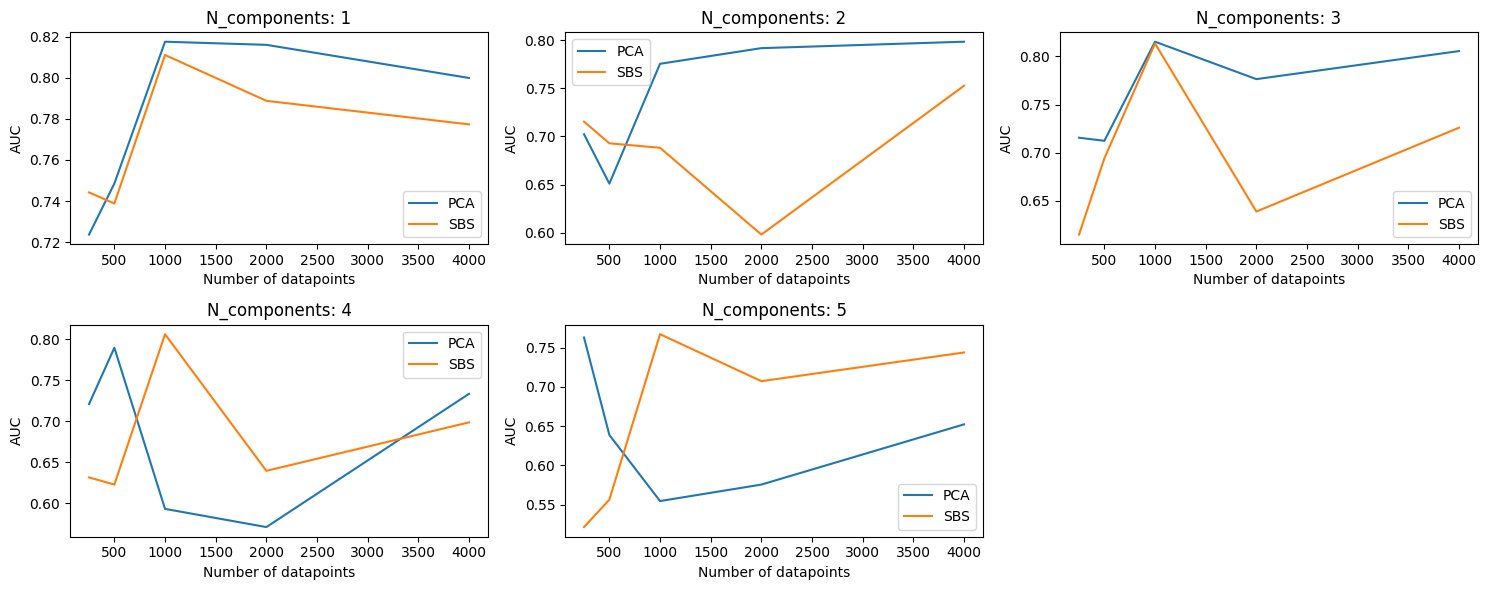

In [17]:
# Plot  the auc roc for the test set as a funtion of the number of datapoints for each number of components/features (i want to see 5 graphics seperatly with individual titles)
num_rows = 2
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 3 * num_rows))
for i, ax in enumerate(axes.flat):
    if i<5:
        ax.plot(n_datapoints_list, auc_test_list_pca[i*5:(i+1)*5], label='PCA')
        ax.plot(n_datapoints_list, auc_test_list_no_pca[i*5:(i+1)*5], label='SBS')
        ax.set_title('N_components: {}'.format(i+1))
        ax.set_xlabel('Number of datapoints')
        ax.set_ylabel('AUC')
        ax.legend()
    else:
        fig.delaxes(ax)

fig.tight_layout()
plt.show()

## VQC

### PCA:VQC - Grid search to find the best hyperparameters

In [18]:
# get the train, test and validation sets
x_train, y_train, w_train, x_val, y_val, w_val, x_test, y_test, w_test = train_val_test(1000,2,'pca','qml')

In [22]:
# loss function
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

# quantum circuit function
def circuit(n_features, n_layers, weights, x):
        # Embedding
        
        qml.AngleEmbedding(x,range (0, n_features),rotation="X" )

        # For every layer
        for layer in range(n_layers):
            W1 = weights[layer]

            # Define Rotations
            for i in range(0,n_features):
                qml.Rot(W1[i, 0], W1[i, 1], W1[i, 2], wires=i)

            # Entanglement
            if n_features != 1:
                if n_features > 2:
                    for i in range(n_features):
                        if i == n_features - 1:
                            qml.CNOT(wires=[i, 0])
                        else:
                            qml.CNOT(wires=[i, i + 1])
                else:
                    qml.CNOT(wires=[1, 0])

        return qml.expval(qml.PauliZ(0))

# classifier function    
def classifier(n_features, n_layers, weights, x):
        #c = circuit(n_features, n_layers, weights, x)
        dev=qml.device("default.qubit", wires=n_features)
        return qml.QNode(circuit, dev)(n_features, n_layers, weights, x)
    
# cost function    
def cost(n_features, n_layers,weights,X,Y,W):  
        # Compute predictions
        y_scores = [(classifier(n_features, n_layers,weights, x) + 1) / 2 for x in X]

        loss = square_loss(Y, y_scores)
        loss = loss * W
        loss = loss.sum()
        
        return loss
    
# train step function    
def train_step(n_features, n_layers,x_train,y_train, w_train, weights, opt,desc='Training'):
        
        # Only require grad if necessary
        x_train = np.array(x_train, requires_grad=False)
        y_train = np.array(y_train, requires_grad=True)
        w_train = np.array(w_train, requires_grad=False)

        # Compute cost and update weights
        weights, loss = opt.step_and_cost(cost, n_features, n_layers,weights, X=x_train, Y=y_train, W=w_train)

        return loss, weights
    
# validation step function
def validation_step(n_features, n_layers, x_val, y_val, w_val, weights, best_score, epoch_number, best_score_epoch,best_weights,desc='Validation'):
    X_val = np.array(x_val, requires_grad=False)
    Y_val = np.array(y_val, requires_grad=False)
    W_val = np.array(w_val, requires_grad=False)

    y_scores = np.array([classifier(n_features, n_layers, weights, x) for x in X_val])
    y_scores = (y_scores + 1) / 2

    W_val[Y_val == 1] = (W_val[Y_val == 1] / W_val[Y_val == 1].sum()) * W_val.shape[0] / 2
    W_val[Y_val == 0] = (W_val[Y_val == 0] / W_val[Y_val == 0].sum()) * W_val.shape[0] / 2

    auc_score = roc_auc_score(y_true=Y_val, y_score=y_scores, sample_weight=W_val)
    loss = cost(n_features, n_layers, weights, X_val, Y_val, W_val)


    if best_score is None or auc_score > best_score:
        best_score = auc_score
        best_score_epoch = epoch_number
        best_weights = weights

    tqdm.write(f"Epoch: {epoch_number}, Validation Loss: {loss:.4f}, AUC Score: {auc_score:.4f}")

    return best_score, best_score_epoch, best_weights
        
        
# train function
def train_vqc(n_features, n_layers, x_train, y_train,w_train,x_val,y_val,w_val, learning_rate, weights, max_epochs):
    opt = AdamOptimizer(learning_rate)
    best_score = None
    best_weights = None
    best_score_epoch = None
    epoch_number = 0

    with tqdm(total=max_epochs, desc='Epoch', unit='epoch') as pbar:
        for epoch in range(epoch_number, max_epochs):
            epoch_number = epoch

            loss, nf_nl_weights = train_step(n_features, n_layers, x_train, y_train, w_train, weights, opt, desc='Training')
            
            # Log variable values using tqdm.write
            tqdm.write(f"Epoch: {epoch_number:}, Loss: {loss:.4f}")
            
            
            weights = nf_nl_weights[2:]
            weights = weights[0]

            if epoch_number == max_epochs - 1 or (epoch_number+1)%5==0:
                best_score, best_score_epoch, best_weights = validation_step(n_features, n_layers, x_val, y_val, w_val, weights, best_score, epoch_number, best_score_epoch, best_weights,desc='Validation')
                # early stopping
                if epoch_number - best_score_epoch > 30 and epoch_number > 80:
                    tqdm.write(f"Early stopping at epoch {epoch_number}")
                    break

            pbar.update(1)  # Update progress bar
        tqdm.write(f"Best Score: {best_score:.4f}")            
        
    return best_score, best_weights


def test_vqc(n_features, n_layers,x_test,y_test,w_test, weights):
        # Remove grad
        X_test = np.array(x_test, requires_grad=False)
        Y_test = np.array(y_test, requires_grad=False)
        W_test = np.array(w_test, requires_grad=False)

        # This will be between -1 and 1, we need to convert to between 0 and 1
        y_scores = np.array([classifier(n_features, n_layers,weights, x) for x in X_test])
        y_scores = (y_scores + 1) / 2

        # Renormalize weights
        W_test[Y_test == 1] = (W_test[Y_test == 1] / W_test[Y_test == 1].sum()) * W_test.shape[0] / 2
        W_test[Y_test == 0] = (W_test[Y_test == 0] / W_test[Y_test == 0].sum()) * W_test.shape[0] / 2

        # Calculate ROC
        auc_score = roc_auc_score(y_true=Y_test, y_score=y_scores, sample_weight=W_test)
        
        return auc_score

In [27]:
n_layers = 3
n_features =2
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]

# Initialize best_score and best_weights
best_score = None
best_weights = None
best_lr = None

# Iterate over each learning rate
for lr in learning_rates:
        # Random weight initialization
        weights = 0.01 * np.random.randn(n_layers, n_features, 3, requires_grad=True)

        # Train the model
        score, weights = train_vqc(n_features, n_layers,x_train,y_train,w_train, x_val,y_val,w_train,lr, weights, 5)

        # Update best_score and best_weights if necessary
        if best_score is None or score > best_score:
            best_score = score
            best_weights = weights
            best_lr = lr

Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 60.2989
Epoch: 1, Loss: 60.2973
Epoch: 2, Loss: 60.2949
Epoch: 3, Loss: 60.2919
Epoch: 4, Loss: 60.2881
Epoch: 4, Validation Loss: 121.1907, AUC Score: 0.4767
Best Score: 0.4767


Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 60.2862
Epoch: 1, Loss: 60.2538
Epoch: 2, Loss: 60.2031
Epoch: 3, Loss: 60.1338
Epoch: 4, Loss: 60.0455
Epoch: 4, Validation Loss: 120.4497, AUC Score: 0.4880
Best Score: 0.4880


Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 60.2542
Epoch: 1, Loss: 60.1334
Epoch: 2, Loss: 59.9417
Epoch: 3, Loss: 59.6772
Epoch: 4, Loss: 59.3389
Epoch: 4, Validation Loss: 118.3100, AUC Score: 0.5157
Best Score: 0.5157


Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 60.2966
Epoch: 1, Loss: 59.2728
Epoch: 2, Loss: 57.1562
Epoch: 3, Loss: 53.7087
Epoch: 4, Loss: 49.2337
Epoch: 4, Validation Loss: 87.8126, AUC Score: 0.6299
Best Score: 0.6299


Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 60.2866
Epoch: 1, Loss: 55.8988
Epoch: 2, Loss: 48.6560
Epoch: 3, Loss: 38.8538
Epoch: 4, Loss: 31.2102
Epoch: 4, Validation Loss: 59.0546, AUC Score: 0.6689
Best Score: 0.6689


Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 60.2903
Epoch: 1, Loss: 29.6824
Epoch: 2, Loss: 50.2150
Epoch: 3, Loss: 39.2646
Epoch: 4, Loss: 36.2445
Epoch: 4, Validation Loss: 59.3163, AUC Score: 0.6689
Best Score: 0.6689


Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 60.2920
Epoch: 1, Loss: 38.0637
Epoch: 2, Loss: 43.1590
Epoch: 3, Loss: 38.6796
Epoch: 4, Loss: 29.8880
Epoch: 4, Validation Loss: 75.8262, AUC Score: 0.6746
Best Score: 0.6746


In [ ]:
'''
# load the best score, best weights and best learning rate
with open('best_score_pca_vqc_all.pickle', 'wb') as handle:
    best_score = pickle.load(handle)

with open('best_weights_pca_vqc_all.pickle', 'wb') as handle:
    best_weights = pickle.load(handle)
 
with open('best_lr_pca_vqca_all.pickle', 'wb') as handle:
    best_lr=pickle.load(best_lr)
    
print (best_score)
print (best_weights)
print (best_lr)

'''

In [29]:
pca_n_features_list = [1,2,3,4,5]
n_layers_list = [1,2,3,4,5]
n_datapoints_list = [250,500,1000,2000,4000]
auc_test_list_pca_vqc = []
auc_val_list_pca_vqc = []
for pca_n_features in pca_n_features_list:
    for n_layers in n_layers_list:
        for n_datapoints in n_datapoints_list:
            weights = 0.01 * np.random.randn(n_layers, pca_n_features, 3, requires_grad=True)
            x_train, y_train, w_train, x_val, y_val, w_val, x_test, y_test, w_test = train_val_test(n_datapoints,pca_n_features,'pca','qml')             
            best_score, best_weights = train_vqc(pca_n_features, n_layers,x_train,y_train,w_train, x_val,y_val,w_train,best_lr, weights, 5)
            auc_score_val = test_vqc(pca_n_features, n_layers,x_val,y_val,w_val, best_weights)
            print('N_components: {}'.format(pca_n_features), 'N_datapoints: {}'.format(n_datapoints), 'N_layers: {}'.format(n_layers))
            print('AUC Val: {}'.format(auc_score_val))
            print('')
            auc_score_test = test_vqc(pca_n_features, n_layers,x_test,y_test,w_test, best_weights)
            print('AUC Test: {}'.format(auc_score_test))
            print('')
            auc_test_list_pca_vqc.append(auc_score_test)
            auc_val_list_pca_vqc.append(auc_score_val)

Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 60.2916
Epoch: 1, Loss: 37.0396
Epoch: 2, Loss: 28.5855
Epoch: 3, Loss: 35.0318
Epoch: 4, Loss: 30.9967
Epoch: 4, Validation Loss: 56.0509, AUC Score: 0.6689
Best Score: 0.6689
N_components: 1 N_datapoints: 250 N_layers: 1
AUC Val: 0.7419797308342647

AUC Test: 0.7247790722589644



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 124.2398
Epoch: 1, Loss: 74.7751
Epoch: 2, Loss: 58.0179
Epoch: 3, Loss: 70.9966
Epoch: 4, Loss: 62.1559
Epoch: 4, Validation Loss: 108.4187, AUC Score: 0.7449
Best Score: 0.7449
N_components: 1 N_datapoints: 500 N_layers: 1
AUC Val: 0.7684924391619996

AUC Test: 0.7430256472954327



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 298.0970
Epoch: 1, Loss: 179.3042
Epoch: 2, Loss: 137.9729
Epoch: 3, Loss: 169.8520
Epoch: 4, Loss: 148.8610
Epoch: 4, Validation Loss: 215.0390, AUC Score: 0.7283
Best Score: 0.7283
N_components: 1 N_datapoints: 1000 N_layers: 1
AUC Val: 0.775643053169053

AUC Test: 0.836317101921882



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 711.2597
Epoch: 1, Loss: 429.6181
Epoch: 2, Loss: 328.4877
Epoch: 3, Loss: 405.4935
Epoch: 4, Loss: 357.7884
Epoch: 4, Validation Loss: 433.3814, AUC Score: 0.6529
Best Score: 0.6529
N_components: 1 N_datapoints: 2000 N_layers: 1
AUC Val: 0.7762487009614114

AUC Test: 0.7990986781055505



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 1470.4573
Epoch: 1, Loss: 880.6148
Epoch: 2, Loss: 676.9262
Epoch: 3, Loss: 833.0222
Epoch: 4, Loss: 730.5680
Epoch: 4, Validation Loss: 862.1669, AUC Score: 0.6992
Best Score: 0.6992
N_components: 1 N_datapoints: 4000 N_layers: 1
AUC Val: 0.76935531137998

AUC Test: 0.8081499637811931



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 60.3002
Epoch: 1, Loss: 40.6998
Epoch: 2, Loss: 46.1927
Epoch: 3, Loss: 38.1414
Epoch: 4, Loss: 35.2967
Epoch: 4, Validation Loss: 58.8090, AUC Score: 0.6689
Best Score: 0.6689
N_components: 1 N_datapoints: 250 N_layers: 2
AUC Val: 0.7419797308342647

AUC Test: 0.7247790722589644



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 124.2459
Epoch: 1, Loss: 86.5555
Epoch: 2, Loss: 104.1415
Epoch: 3, Loss: 87.6281
Epoch: 4, Loss: 65.8212
Epoch: 4, Validation Loss: 125.1101, AUC Score: 0.7449
Best Score: 0.7449
N_components: 1 N_datapoints: 500 N_layers: 2
AUC Val: 0.7684924467955978

AUC Test: 0.7430256472954327



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 298.0100
Epoch: 1, Loss: 187.5646
Epoch: 2, Loss: 218.5842
Epoch: 3, Loss: 210.3808
Epoch: 4, Loss: 187.3369
Epoch: 4, Validation Loss: 223.0124, AUC Score: 0.7283
Best Score: 0.7283
N_components: 1 N_datapoints: 1000 N_layers: 2
AUC Val: 0.7756430547534372

AUC Test: 0.836317101921882



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 711.2341
Epoch: 1, Loss: 454.6876
Epoch: 2, Loss: 545.5871
Epoch: 3, Loss: 448.4053
Epoch: 4, Loss: 385.8362
Epoch: 4, Validation Loss: 488.6630, AUC Score: 0.6529
Best Score: 0.6529
N_components: 1 N_datapoints: 2000 N_layers: 2
AUC Val: 0.7762535736428293

AUC Test: 0.7990986627242275



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 1470.4504
Epoch: 1, Loss: 911.0758
Epoch: 2, Loss: 1150.9353
Epoch: 3, Loss: 915.5681
Epoch: 4, Loss: 798.3609
Epoch: 4, Validation Loss: 962.1337, AUC Score: 0.6992
Best Score: 0.6992
N_components: 1 N_datapoints: 4000 N_layers: 2
AUC Val: 0.7693558050248193

AUC Test: 0.8081499481095541



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 60.2996
Epoch: 1, Loss: 29.9469
Epoch: 2, Loss: 56.9357
Epoch: 3, Loss: 30.5245
Epoch: 4, Loss: 32.3327
Epoch: 4, Validation Loss: 93.1965, AUC Score: 0.6532
Best Score: 0.6532
N_components: 1 N_datapoints: 250 N_layers: 3
AUC Val: 0.7259821039410213

AUC Test: 0.7243539831324549



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 124.2473
Epoch: 1, Loss: 123.8428
Epoch: 2, Loss: 92.7204
Epoch: 3, Loss: 87.6749
Epoch: 4, Loss: 112.2513
Epoch: 4, Validation Loss: 121.2809, AUC Score: 0.7449
Best Score: 0.7449
N_components: 1 N_datapoints: 500 N_layers: 3
AUC Val: 0.7684924467955978

AUC Test: 0.7430256472954327



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 298.1077
Epoch: 1, Loss: 297.5951
Epoch: 2, Loss: 137.5465
Epoch: 3, Loss: 176.8334
Epoch: 4, Loss: 185.8046
Epoch: 4, Validation Loss: 224.4724, AUC Score: 0.7283
Best Score: 0.7283
N_components: 1 N_datapoints: 1000 N_layers: 3
AUC Val: 0.7756430515846685

AUC Test: 0.836317101921882



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 711.0653
Epoch: 1, Loss: 329.4039
Epoch: 2, Loss: 512.6332
Epoch: 3, Loss: 496.5563
Epoch: 4, Loss: 541.2621
Epoch: 4, Validation Loss: 472.8659, AUC Score: 0.6529
Best Score: 0.6529
N_components: 1 N_datapoints: 2000 N_layers: 3
AUC Val: 0.7762487112896337

AUC Test: 0.7990986781055505



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 1470.5218
Epoch: 1, Loss: 741.7510
Epoch: 2, Loss: 1358.6482
Epoch: 3, Loss: 1443.0962
Epoch: 4, Loss: 1140.8587
Epoch: 4, Validation Loss: 1226.6929, AUC Score: 0.3008
Best Score: 0.3008
N_components: 1 N_datapoints: 4000 N_layers: 3
AUC Val: 0.230644683128053

AUC Test: 0.19185003634857561



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 60.2866
Epoch: 1, Loss: 30.5377
Epoch: 2, Loss: 29.9148
Epoch: 3, Loss: 28.3816
Epoch: 4, Loss: 28.8910
Epoch: 4, Validation Loss: 69.9394, AUC Score: 0.6385
Best Score: 0.6385
N_components: 1 N_datapoints: 250 N_layers: 4
AUC Val: 0.7178326101560334

AUC Test: 0.7155302823655644



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 124.2457
Epoch: 1, Loss: 71.5087
Epoch: 2, Loss: 67.1163
Epoch: 3, Loss: 86.7766
Epoch: 4, Loss: 87.8856
Epoch: 4, Validation Loss: 124.2605, AUC Score: 0.7449
Best Score: 0.7449
N_components: 1 N_datapoints: 500 N_layers: 4
AUC Val: 0.7684924009940088

AUC Test: 0.7430256472954327



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 298.1098
Epoch: 1, Loss: 174.7228
Epoch: 2, Loss: 161.8741
Epoch: 3, Loss: 208.5383
Epoch: 4, Loss: 189.0038
Epoch: 4, Validation Loss: 237.0271, AUC Score: 0.7283
Best Score: 0.7283
N_components: 1 N_datapoints: 1000 N_layers: 4
AUC Val: 0.775643048173059

AUC Test: 0.836317101921882



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 711.0843
Epoch: 1, Loss: 521.5279
Epoch: 2, Loss: 554.5286
Epoch: 3, Loss: 472.5878
Epoch: 4, Loss: 494.3397
Epoch: 4, Validation Loss: 637.0759, AUC Score: 0.5222
Best Score: 0.5222
N_components: 1 N_datapoints: 2000 N_layers: 4
AUC Val: 0.45936743945784264

AUC Test: 0.4171456496122058



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 1469.7353
Epoch: 1, Loss: 841.8002
Epoch: 2, Loss: 775.3677
Epoch: 3, Loss: 1142.7995
Epoch: 4, Loss: 971.4808
Epoch: 4, Validation Loss: 1832.5428, AUC Score: 0.6122
Best Score: 0.6122
N_components: 1 N_datapoints: 4000 N_layers: 4
AUC Val: 0.7014513682663348

AUC Test: 0.7608228138533717



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 60.3013
Epoch: 1, Loss: 43.9062
Epoch: 2, Loss: 28.0577
Epoch: 3, Loss: 34.3811
Epoch: 4, Loss: 35.7403
Epoch: 4, Validation Loss: 91.2341, AUC Score: 0.6750
Best Score: 0.6750
N_components: 1 N_datapoints: 250 N_layers: 5
AUC Val: 0.7496211996977409

AUC Test: 0.7247781764838663



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 124.2165
Epoch: 1, Loss: 81.5874
Epoch: 2, Loss: 122.4161
Epoch: 3, Loss: 93.5583
Epoch: 4, Loss: 113.7647
Epoch: 4, Validation Loss: 181.0127, AUC Score: 0.2565
Best Score: 0.2565
N_components: 1 N_datapoints: 500 N_layers: 5
AUC Val: 0.23228219428721514

AUC Test: 0.25710445051986497



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 298.0407
Epoch: 1, Loss: 189.7422
Epoch: 2, Loss: 295.2261
Epoch: 3, Loss: 236.4985
Epoch: 4, Loss: 235.8849
Epoch: 4, Validation Loss: 418.5639, AUC Score: 0.2973
Best Score: 0.2973
N_components: 1 N_datapoints: 1000 N_layers: 5
AUC Val: 0.2454581732331353

AUC Test: 0.17685183441069516



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 711.2540
Epoch: 1, Loss: 470.7812
Epoch: 2, Loss: 393.7739
Epoch: 3, Loss: 380.2729
Epoch: 4, Loss: 472.7884
Epoch: 4, Validation Loss: 549.3829, AUC Score: 0.6528
Best Score: 0.6528
N_components: 1 N_datapoints: 2000 N_layers: 5
AUC Val: 0.7762403637608879

AUC Test: 0.799095760756165



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 1470.4067
Epoch: 1, Loss: 984.3371
Epoch: 2, Loss: 798.4209
Epoch: 3, Loss: 688.5157
Epoch: 4, Loss: 1198.8148
Epoch: 4, Validation Loss: 1513.3277, AUC Score: 0.6993
Best Score: 0.6993
N_components: 1 N_datapoints: 4000 N_layers: 5
AUC Val: 0.7702472283008397

AUC Test: 0.8102809939244726



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 31.5842
Epoch: 1, Loss: 30.0184
Epoch: 2, Loss: 32.3293
Epoch: 3, Loss: 32.6480
Epoch: 4, Loss: 30.6271
Epoch: 4, Validation Loss: 62.1835, AUC Score: 0.6153
Best Score: 0.6153
N_components: 2 N_datapoints: 250 N_layers: 1
AUC Val: 0.6658026494132875

AUC Test: 0.7926810462914977



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 66.1185
Epoch: 1, Loss: 71.5659
Epoch: 2, Loss: 66.0762
Epoch: 3, Loss: 62.8838
Epoch: 4, Loss: 61.8212
Epoch: 4, Validation Loss: 130.9563, AUC Score: 0.6487
Best Score: 0.6487
N_components: 2 N_datapoints: 500 N_layers: 1
AUC Val: 0.601813335821581

AUC Test: 0.6614330864351355



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 159.2002
Epoch: 1, Loss: 164.3656
Epoch: 2, Loss: 153.3385
Epoch: 3, Loss: 167.5684
Epoch: 4, Loss: 169.1494
Epoch: 4, Validation Loss: 265.9685, AUC Score: 0.3155
Best Score: 0.3155
N_components: 2 N_datapoints: 1000 N_layers: 1
AUC Val: 0.39932378832401927

AUC Test: 0.315132971452607



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 374.5739
Epoch: 1, Loss: 408.1377
Epoch: 2, Loss: 377.0708
Epoch: 3, Loss: 359.7074
Epoch: 4, Loss: 349.7767
Epoch: 4, Validation Loss: 522.4321, AUC Score: 0.6790
Best Score: 0.6790
N_components: 2 N_datapoints: 2000 N_layers: 1
AUC Val: 0.6661564755771844

AUC Test: 0.7515155530801874



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 778.5926
Epoch: 1, Loss: 842.0599
Epoch: 2, Loss: 779.3898
Epoch: 3, Loss: 742.3319
Epoch: 4, Loss: 730.1872
Epoch: 4, Validation Loss: 1020.6167, AUC Score: 0.7117
Best Score: 0.7117
N_components: 2 N_datapoints: 4000 N_layers: 1
AUC Val: 0.7325180383473219

AUC Test: 0.7286468878584171



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 60.3217
Epoch: 1, Loss: 43.1240
Epoch: 2, Loss: 55.7630
Epoch: 3, Loss: 45.0284
Epoch: 4, Loss: 39.4740
Epoch: 4, Validation Loss: 78.5274, AUC Score: 0.5746
Best Score: 0.5746
N_components: 2 N_datapoints: 250 N_layers: 2
AUC Val: 0.6657230024414513

AUC Test: 0.6247006107880567



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 124.2084
Epoch: 1, Loss: 90.3366
Epoch: 2, Loss: 81.5461
Epoch: 3, Loss: 61.7661
Epoch: 4, Loss: 58.8072
Epoch: 4, Validation Loss: 183.5570, AUC Score: 0.7782
Best Score: 0.7782
N_components: 2 N_datapoints: 500 N_layers: 2
AUC Val: 0.7774773075327457

AUC Test: 0.7466040456415622



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 297.8551
Epoch: 1, Loss: 169.6555
Epoch: 2, Loss: 179.0435
Epoch: 3, Loss: 162.0156
Epoch: 4, Loss: 163.6157
Epoch: 4, Validation Loss: 290.4864, AUC Score: 0.6877
Best Score: 0.6877
N_components: 2 N_datapoints: 1000 N_layers: 2
AUC Val: 0.7565900658553474

AUC Test: 0.8041074376082276



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 711.8341
Epoch: 1, Loss: 512.1284
Epoch: 2, Loss: 636.5407
Epoch: 3, Loss: 476.1161
Epoch: 4, Loss: 506.5954
Epoch: 4, Validation Loss: 530.1422, AUC Score: 0.5667
Best Score: 0.5667
N_components: 2 N_datapoints: 2000 N_layers: 2
AUC Val: 0.6536002860778642

AUC Test: 0.6565565429148799



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 1470.0001
Epoch: 1, Loss: 844.1944


In [ ]:
'''
# load the best score, best weights and best learning rate
with open('auc_test_list_pca_vqc.pickle', 'wb') as handle:
    auc_test_list_pca_vqc= load(handle)

with open('auc_val_list_pca_vqc.pickle', 'wb') as handle:
    auc_val_list_pca_vqc.pickle= load(handle)
 
print (auc_test_list_pca_vqc)
print (auc_val_list_pca_vqc)

'''

### Without PCA:VQC -Grid search to find the best hyperparameters

In [ ]:
# get the train, test and validation sets
x_train, y_train, w_train, x_val, y_val, w_val, x_test, y_test, w_test = train_val_test(1000,2,'sbs','qml')

In [ ]:
n_layers = 3
n_features =2
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]

# Initialize best_score and best_weights
best_score = None
best_weights = None
best_lr = None

# Iterate over each learning rate
for lr in learning_rates:
        # Random weight initialization
        weights = 0.01 * np.random.randn(n_layers, n_features, 3, requires_grad=True)

        # Train the model
        score, weights = train_vqc(n_features, n_layers,x_train,y_train,w_train, x_val,y_val,w_train,lr, weights, 5)

        # Update best_score and best_weights if necessary
        if best_score is None or score > best_score:
            best_score = score
            best_weights = weights
            best_lr = lr

In [ ]:
'''
# load the best score, best weights and best learning rate
with open('best_score_no_pca_vqc_all.pickle', 'wb') as handle:
    best_score = pickle.load(handle)

with open('best_weights_no_pca_vqc_all.pickle', 'wb') as handle:
    best_weights = pickle.load(handle)
 
with open('best_lr_no_pca_vqca_all.pickle', 'wb') as handle:
    best_lr=pickle.load(handle)
    
print (best_score)
print (best_weights)
print (best_lr)

'''

In [ ]:
n_features_list = [1,2,3,4,5]
n_layers_list = [1,2,3,4,5]
n_datapoints_list = [250,500,1000,2000,4000]
auc_test_list_no_pca_vqc = []
auc_val_list_no_pca_vqc = []
for n_features in n_features_list:
    for n_layers in n_layers_list:
        for n_datapoints in n_datapoints_list:
            weights = 0.01 * np.random.randn(n_layers, n_features, 3, requires_grad=True)
            x_train, y_train, w_train, x_val, y_val, w_val, x_test, y_test, w_test = train_val_test(n_datapoints,n_features,'pca','qml')             
            best_score, best_weights = train_vqc(n_features, n_layers,x_train,y_train,w_train, x_val,y_val,w_train,best_lr, weights, 5)
            auc_score_val = test_vqc(n_features, n_layers,x_val,y_val,w_val, best_weights)
            print('N_components: {}'.format(n_features), 'N_datapoints: {}'.format(n_datapoints), 'N_layers: {}'.format(n_layers))
            print('AUC Val: {}'.format(auc_score_val))
            print('')
            auc_score_test = test_vqc(n_features, n_layers,x_test,y_test,w_test, best_weights)
            print('AUC Test: {}'.format(auc_score_test))
            print('')
            auc_test_list_no_pca_vqc.append(auc_score_test)
            auc_val_list_no_pca_vqc.append(auc_score_val)

In [ ]:
'''
# load the best score, best weights and best learning rate
with open('auc_test_list_no_pca_vqc.pickle', 'wb') as handle:
    auc_test_list_pca_vqc = pickle.load(handle)

with open('auc_val_list_no_pca_vqc.pickle ', 'wb') as handle:
    auc_val_list_pca_vqc = pickle.load(handle)
 
print (auc_test_list_no_pca_vqc)
print (auc_val_list_no_pca_vqc)

'''

### PLOT

In [ ]:
# Plot  the auc roc for the test set as a funtion of the number of datapoints for each number of components/features (i want to see 5 graphics seperatly with individual titles)
num_rows = 9
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 3 * num_rows))
for i, ax in enumerate(axes.flat):
    if i<25:
        ax.plot(n_datapoints_list, auc_test_list_pca[i*5:(i+1)*5], label='PCA')
        ax.plot(n_datapoints_list, auc_test_list_no_pca[i*5:(i+1)*5], label='SBS')
        ax.set_title('{} features: '.format((i//5)+1) and 'N_layers: {}'.format(i%5)+1)
        ax.set_xlabel('Number of datapoints')
        ax.set_ylabel('AUC')
        ax.legend()
    else:
        fig.delaxes(ax)

fig.tight_layout()
plt.show()